In [20]:
# Muhammad Abdullah Ijaz  HHL (QLS)

from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import numpy as np

from qiskit import BasicAer, Aer, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.circuit.library import QFT

References

https://arxiv.org/pdf/0811.3171.pdf

https://arxiv.org/pdf/2108.09004.pdf

https://github.com/hywong2/HHL_Example/blob/main/HHL_Hector_Wong.ipynb

A = {{a b} {c d}}

a =1
b =-1/3
c =-1/3
d =1

Note: a,b,c,d must be real non zero numbers.

C = {{0 A} {A' 0}} , where A' is A dagger

|V> = |0 v>

let v =0


In [21]:
# Create the various registers needed
cont_qub = 4
ancil_qub = 1
vect_qub = 2

ancil = QuantumRegister(ancil_qub, 'ancil')
cont = QuantumRegister(cont_qub, 'cont')
vect = QuantumRegister(vect_qub, 'vect')
measure = ClassicalRegister(3, name='m')

#Define Hamiltonian

a =1
b =-1/3
c =-1/3
d =1

t = -1  
#t = 3*np.pi/32    

A = [[a,b],[c,d]]

In [22]:
def hamil(qc, A ,con, qub, name= 'Ham'):
    
    qc.cswap(con, qub[0], qub[1])        # Swap
    
    if(A[0][0] != 0):
        qc.crx(2*A[0][0]*t, con, qub[0])    # Rx(2at)
    if(A[1][1] != 0):
        qc.crx(2*A[1][1]*t, con, qub[1])    # Rx(2dt)
    
    qc.ccx(con,  qub[0], qub[1])         # Cnot
    qc.cswap(con, qub[0], qub[1])        # Swap
    
    if(A[0][1] != 0):
        qc.crx(2*A[0][1]*t, con, qub[0])    # Rx(2bt)
    if(A[1][0] != 0):
        qc.crx(2*A[1][0]*t, con, qub[1])    # Rx(2ct)

    qc.ccx(con, qub[1], qub[0])         # Cnot

In [23]:
def hamil_d(qc, A ,con, qub, name= 'Ham_d'):
    
    qc.ccx(con,  qub[1], qub[0])         # Cnot
    
    if(A[1][0] != 0):
        qc.crx(-2*A[1][0]*t, con, qub[1])    # Rx(2ct)
    if(A[0][1] != 0):
        qc.crx(-2*A[0][1]*t, con, qub[0])    # Rx(2bt)
    
    qc.cswap(con, qub[0], qub[1])        # Swap
    qc.ccx(con,  qub[0], qub[1])         # Cnot
    
    if(A[1][1] != 0):
        qc.crx(-2*A[1][1]*t, con, qub[1])    # Rx(2dt)
    if(A[0][0] != 0):
        qc.crx(-2*A[0][0]*t, con, qub[0])    # Rx(2at)
    
    qc.cswap(con, qub[0], qub[1])        # Swap

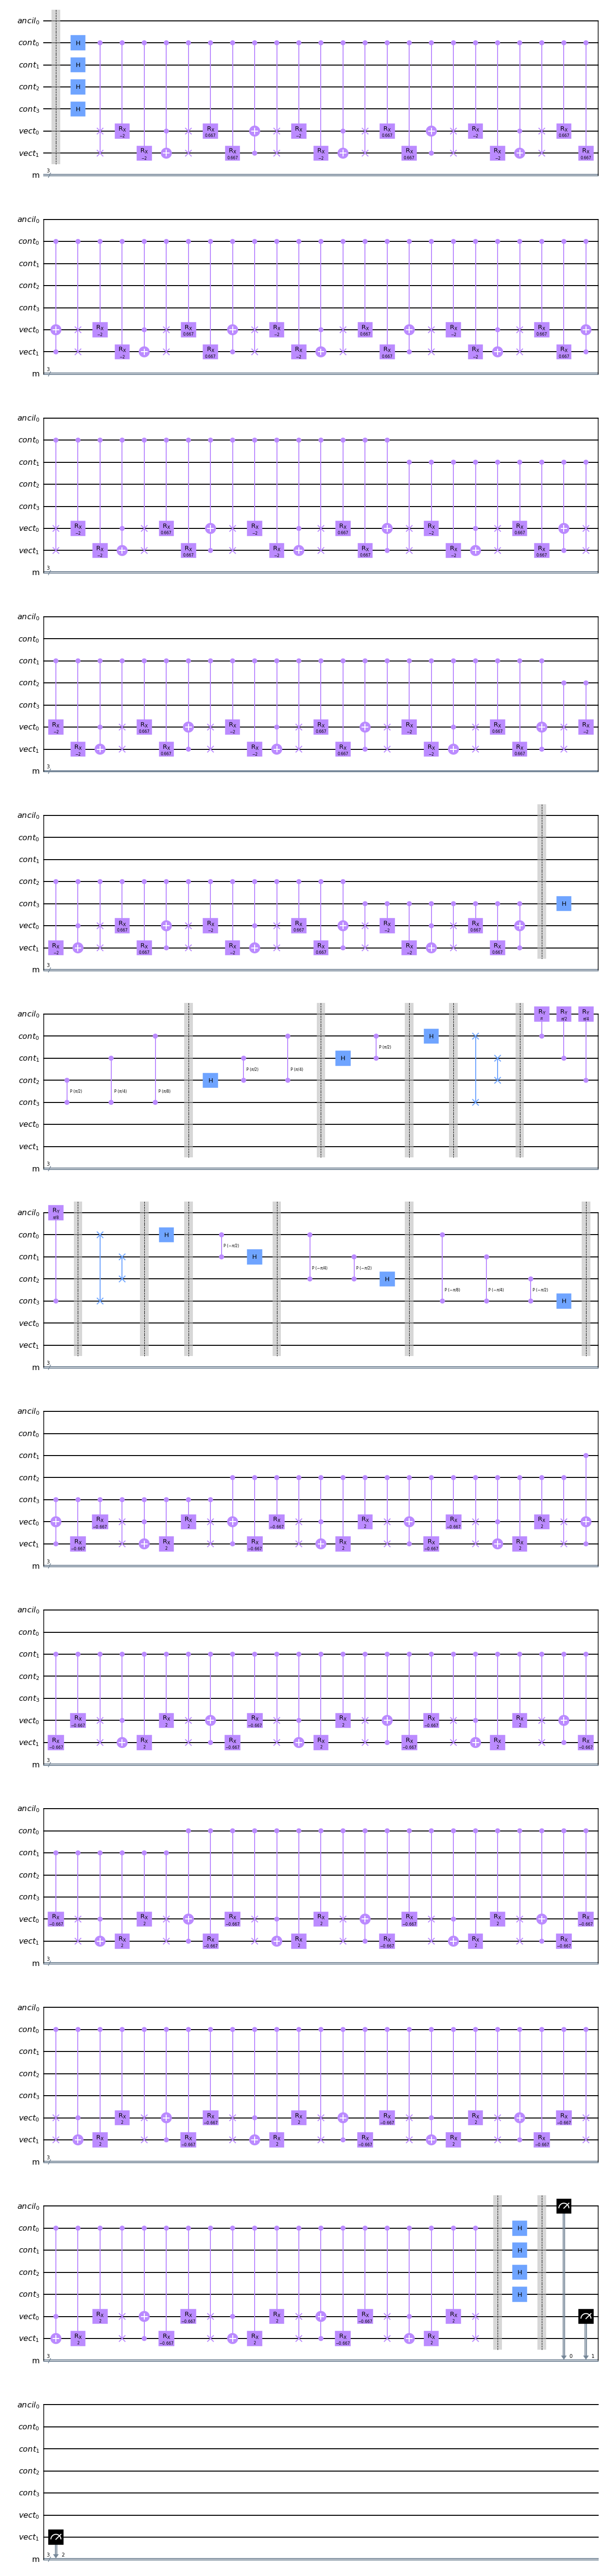

In [24]:
#Initilaizing the circuit
hhl = QuantumCircuit(ancil, cont, vect, measure)

# Vect in b state = |0>
#hhl.x(vect[0])
#hhl.h(vect[0])

hhl.barrier()

# Quantum Pahse Estimation
hhl.h(cont)

for i in range(cont_qub):
    for j in range( 2**(cont_qub-i-1)):
        hamil(hhl, A, cont[i], vect)  # U is applied

hhl.barrier()
#Inverse QFT
for i in range(cont_qub-1,-1,-1):
    hhl.h(cont[i])
    p=0
    for j in range(i):
        p+=1
        hhl.cp(np.pi/(2**(p)),cont[i-j-1],cont[i])
    hhl.barrier()

for i in range(int(cont_qub/2)):
    hhl.swap(cont[i],cont[cont_qub-i-1])

hhl.barrier()

#Rotation about ancilla
for i in range(cont_qub):
    hhl.cry(np.pi/(2**i), cont[i], ancil)

hhl.barrier()

# Inverse Quantum Phase Estimation

#QFT
for i in range(int(cont_qub/2)):
    hhl.swap(cont[i],cont[cont_qub-i-1])

hhl.barrier()

for i in range(cont_qub):
    p=i+1
    for j in range(i):
        p-=1
        hhl.cp(-np.pi/(2**(p)),cont[j],cont[i])
    hhl.h(cont[i])
    hhl.barrier()
    

for i in range(cont_qub):
    for j in range(2**i):
        hamil_d(hhl, A, cont[cont_qub-i-1], vect)  # U dagger is applied

hhl.barrier()
hhl.h(cont)
hhl.barrier()


# Measuring Result
hhl.measure(ancil, measure[0])
hhl.measure(vect[0], measure[1])
hhl.measure(vect[1], measure[2])


hhl.draw('mpl')

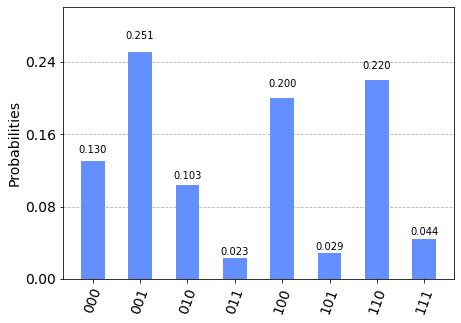

In [25]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(hhl, backend=simulator, shots=10000).result().get_counts()
plot_histogram(counts)

Classical LS

|0 x>  =  C^(-1) |v 0>
where v = 0

|x> = 0.75|0> + 0.25|1>


Quantum Ls

|1 0 x>  =  C^(-1) |0 v 0>
where v = 1

where |1 0 x>  =  |ancillia vect(0) vect(1)>
 

|1 0 x> = sqrt(0.259)|1 0 0> + sqrt(0.031)|1 0 1>

|x> = 0.508|0> + 0.176|1>

Normalized

|x> = 0.743|0> + 0.257|1>


Error = sqrt((0.743-0.75)^2 + (0.257-0.25)^2)

Error = 0.01